In [9]:
reset -f

In [10]:
import json
import pandas as pd
import numpy as np
import re
from collections import Counter
import string
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('ggplot')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
#load tweets json into dataframe
with open('trump_tweets_oct11.json') as data_file:    
    data = json.load(data_file)
    
tweets = pd.read_json(json.dumps(data))


#create new column device which tells if a tweet is from iphone or android or other

tweets.loc[:, 'device'] = tweets['source'] \
.apply(lambda x : 'android' if 'android' in x.lower() else ('iphone' if 'iphone' in x.lower() else 'other'))

#extract the hour from the tweet time. 
tweets.loc[:,'hour'] = pd.to_datetime(tweets['created_at']).apply(lambda x : int(x.hour))



In [12]:
stopwords = pd.read_csv('stopwords')
stop = stopwords['word "lexicon"'].str.split().str.get(1).values
stopwords = set(stop)
extrawords = ["dont", "no", "but"]
stopwords = [re.sub(r"['\"]","", x) for x in stopwords]

for i in extrawords:
    stopwords.append(i)
    

In [13]:
# make a new series where each column is a word from the tweets
# add device label for each tweet. and use the device label as the index
# rotate the resulting dataframe, so that each row presents a word and device label

seriesText = tweets['text'].str.split().apply(lambda x: pd.Series(x))
tab1 = pd.concat([seriesText,tweets['device']],axis=1).set_index('device')
wordsRows = tab1.unstack(level=1).reset_index()
wordsRows.dropna(inplace=True)
wordsRows.rename(columns= {0: 'word'},inplace=True)

# remove punctuation, stopwords, single letters, remove non-ascii characters

removePunct =  wordsRows['word'].apply(lambda x : re.sub(r"[@#\?\!,\-:\"\'\.\\(\\)]","", x.lower()))
wordsRows['cleanWord'] = removePunct.apply(lambda x : re.sub(r"[^\x00-\x7F]+","", x))

pred = wordsRows['cleanWord'].map(lambda x : x.isalpha())
filteredTab = wordsRows[(~wordsRows['cleanWord'].isin(stopwords)) & pred]
filteredTab.drop(['level_0'], axis = 1, inplace=True)
filteredTab.head()


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,device,word,cleanWord
2,android,.@MarkHalperin,markhalperin
3,android,Bill,bill
6,android,Jeb,jeb
7,android,"""@BornToBeGOP:",borntobegop
12,android,Hillary,hillary


In [14]:
#put sentiment word list into a dataframe

with open('NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt') as data_file:    
    data = data_file.read()

nrcList = data[data.find("aback"):].split('\n')
sentimentList = [i.split('\t') for i in nrcList[:-1]]
senti = pd.DataFrame(sentimentList)
sen1 = senti.pivot(index  =  0, columns = 1, values = 2)
sen1.head()

1,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


In [15]:
# remove hashtags, @ non-alphabets from the filtered tweets. 
#join the tweets onto the the sentiments word bank, so each word has a labeled sentiment
wordsen = filteredTab.set_index('cleanWord').join(sen1)
wordsen.head()


,device,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
abandon,iphone,abandon,0,0,0,1,0,1,0,1,0,0
abandon,iphone,abandon,0,0,0,1,0,1,0,1,0,0
abandoned,iphone,abandoned,1,0,0,1,0,1,0,1,0,0
abc,android,@ABC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abc,android,@ABC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#remove words which have missing entries in all sentiments

notmissing = wordsen[~wordsen[wordsen.columns[2:]].isnull().all(axis = 1)]

for i in wordsen.columns[2:]:
    notmissing.loc[:, i] = notmissing[i].astype(int)

notmissing.reset_index(inplace = True)
notmissing.head()

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,index,device,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abandon,iphone,abandon,0,0,0,1,0,1,0,1,0,0
1,abandon,iphone,abandon,0,0,0,1,0,1,0,1,0,0
2,abandoned,iphone,abandoned,1,0,0,1,0,1,0,1,0,0
3,ability,android,ability.,0,0,0,0,0,0,1,0,0,0
4,ability,android,"ability,",0,0,0,0,0,0,1,0,0,0


In [17]:
#count all the sentiments by device
tabSentiment = notmissing.groupby('device')[wordsen.columns[1:]].sum()
crapper = tabSentiment.sum(axis =1)
tabSentiment['tots'] = crapper

In [18]:
tabSentiment

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,tots
device,,,,,,,,,,,
android,802,756,529,665,645,1396,1636,748,669,1084,8930
iphone,400,524,235,343,414,691,1171,381,314,764,5237
other,112,86,60,100,73,198,242,108,82,148,1209


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


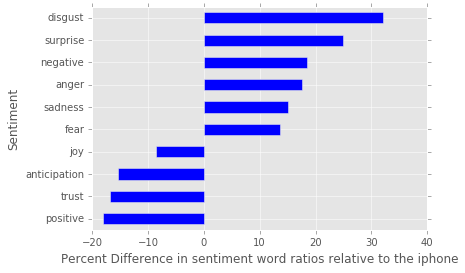

In [19]:
#Calculate percent increase relative to iphone
# (android/totAndroid - iphone/totIphone)/ (iphone/totIphone)

sentimentRatio = tabSentiment.div(tabSentiment.tots,axis =0)
perInc = 100*(sentimentRatio.loc['android'] -  sentimentRatio.loc['iphone'])/ sentimentRatio.loc['iphone']
perInc.drop('tots',inplace=True)
perInc.sort()

plt.figure()
ax = perInc.plot.barh()
ax.set_ylabel('Sentiment')
ax.set_xlabel('Percent Difference in sentiment word ratios relative to the iphone')
plt.savefig("sentiment.png")


# An attempt to determine confidence intervals but using normal distribution to approximate

In [22]:
# try a two sample test for poisson rate, but using a normal distribution to approximate. 
# test the Z statistic: c*X -Y/sqrt(c^2 X+Y) 
# where c = iphone_total/android_total,and  X,Y is android_sentiment, iphone_sentiment

c = tabSentiment['tots'].loc['iphone']/float(tabSentiment['tots'].loc['android'])
mu = c*tabSentiment.loc['android'] - tabSentiment.loc['iphone'] 
std = np.sqrt(c*c*tabSentiment.loc['android'] + tabSentiment.loc['iphone'])

lower, upper = mu-1.96*std , mu+1.96*std

#errors for the percent relative increase ...
errors = pd.DataFrame([100* lower/tabSentiment.loc['iphone'], 100* upper/tabSentiment.loc['iphone']],index=['lower','upper']).T
errors.drop('tots',inplace=True)
errors = errors.loc[perInc.index]

In [21]:
# sentiment ratios with their confidence intervals.
ratios= pd.concat([perInc,errors], axis =1)
ratios

,0,lower,upper
positive,-18.067252,-25.036422,-11.098082
trust,-16.791625,-25.441450,-8.141801
anticipation,-15.390014,-25.863339,-4.916689
joy,-8.632764,-20.570625,3.305098
fear,13.699522,0.036412,27.362633
sadness,15.135099,2.138545,28.131652
anger,17.583259,4.844890,30.321627
negative,18.478210,8.771361,28.185060
surprise,24.947504,10.387556,39.507451
disgust,32.013676,14.983359,49.043994
